# Transfer learning with the Neural Force Field

This Jupyter Notebook contains a demonstration on how to use the `nff` package to transfer learning between different methods. Most of it is similar to the first tutorial, and we'll go through the same steps when setting it up. The difference, however, is that we'll now load a pretrained model instead of training one from scratch.

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts
from nff.train import Trainer, get_trainer, load_model, loss, hooks, metrics, evaluate
from nff.train.transfer import freeze_parameters, unfreeze_readout

In [2]:
DEVICE = 1
INDIR = './sandbox'
OUTDIR = './sandbox/transfer'

if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
    os.mkdir(OUTDIR)

## Loading the relevant data

The dataset we'll work with contains ~500 geometries of ethanol, each calculated with the DLPNO-CCSD(T) level of theory. The procedure to create the validation sets will be exactly the same.

In [3]:
gga_dataset = Dataset.from_file('./data/dataset.pth.tar')
dlpno_dataset = Dataset.from_file('./data/dataset_dlpno_TEST.pth.tar')

In [4]:
train, val, test = split_train_validation_test(dlpno_dataset, val_size=0.2, test_size=0.2)

In [5]:
gga_loader = DataLoader(gga_dataset, batch_size=50, collate_fn=collate_dicts)
dlpno_loader = DataLoader(dlpno_dataset, batch_size=50, collate_fn=collate_dicts)
train_loader = DataLoader(train, batch_size=50, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=50, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=50, collate_fn=collate_dicts)

## Loading the pretrained model and freezing its convolution layers

`INDIR` contains the path for the pretrained model.

In [6]:
model = load_model(INDIR)

Now we just have to freeze its convolution layers and unfreeze the last layers. In our case, the readout layers are those which make the prediction possible.

In [7]:
model = freeze_parameters(model)
unfreeze_readout(model)

And the loss function for this model:

In [8]:
loss_fn = loss.build_mse_loss(loss_coef={'energy': 0.01, 'energy_grad': 1})

### Testing the performance of this model in the datasets:

Before starting the transfer learning, it might be interesting to do some tests on the performance of the model before and after the calculations. Evaluating the model on the GGA dataset:

In [9]:
results, targets, val_loss = evaluate(model, gga_loader, loss_fn, device=DEVICE)

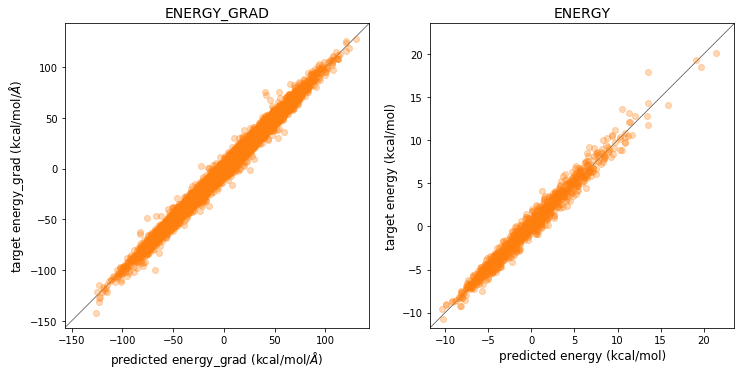

In [10]:
units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred = torch.cat(results[key], dim=0).detach().cpu().numpy()
    targ = torch.cat(targets[key], dim=0).detach().cpu().numpy()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)

plt.show()

In [11]:
results, targets, val_loss = evaluate(model, dlpno_loader, loss_fn, device=DEVICE)

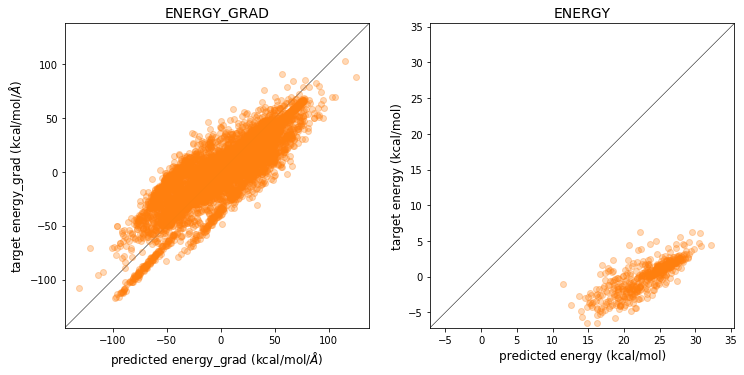

In [12]:
units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred = torch.cat(results[key], dim=0).detach().cpu().numpy()
    targ = torch.cat(targets[key], dim=0).detach().cpu().numpy()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)

plt.show()

## Creating a trainer

We should also select an optimizer for our recently created model:

In [13]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

### Metrics and hooks

Metrics and hooks allow the customization of the training process. Instead of tweaking directly the code or having to resort to countless flags, we can create submodules (or add-ons) to monitor the progress of the training or customize it.

If we want to monitor the progress of our training, say by looking at the mean absolute error (MAE) of energies and forces, we can simply create metrics to observe them:

In [14]:
train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]

Furthermore, if we want to customize how our training procedure is done, we can use hooks which can interrupt or change the train automatically.

In our case, we are adding hooks to:
* Stop the training procedure after 100 epochs;
* Log the training on a machine-readable CSV file under the directory `./sandbox`;
* Print the progress on the screen with custom formatting; and
* Setup a scheduler for the learning rate.

In [15]:
train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S',
        log_memory=False
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

### Trainer wrapper

A `Trainer` in the `nff` package is a wrapper to train a model. It automatically creates checkpoints, as well as trains and validates a given model. It also allow further training by loading checkpoints from existing paths, making the training procedure more flexible. Its functionalities can be extended by the hooks we created above. To create a trainer, we have to execute the following command:

In [16]:
T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks
)

Now we can finally train the model using the method `train` from the `Trainer`:

In [17]:
T.train(device=DEVICE, n_epochs=100)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | 
36:41 |     1 |     3.000e-04 |   161.6876 |        118.0502 |    20.9386 |          6.9295 | 
36:41 |     2 |     3.000e-04 |   104.8061 |         90.5912 |    17.1343 |          6.3780 | 
36:41 |     3 |     3.000e-04 |    81.6076 |         68.8194 |    12.8990 |          5.4994 | 
36:41 |     4 |     3.000e-04 |    61.9266 |         51.6110 |     9.2715 |          4.6973 | 
36:42 |     5 |     3.000e-04 |    47.7094 |         39.9883 |     6.7820 |          4.2925 | 
36:42 |     6 |     3.000e-04 |    37.8742 |         32.0645 |     5.2342 |          3.9980 | 
36:42 |     7 |     3.000e-04 |    31.7628 |         27.8669 |     3.8221 |          3.8221 | 
36:43 |     8 |     3.000e-04 |    28.3447 |         25.0122 |     2.1358 |          3.6521 | 
36:43 |     9 |     3.000e-04 |    25.8783 |         23.0936 |     0.8773 |          3.5156 | 
36:43 |    10 |     3.000e-04 |    24.1357 |      

37:06 |    87 |     3.000e-04 |     5.7366 |          5.4525 |     0.2965 |          1.5494 | 
37:06 |    88 |     3.000e-04 |     5.6810 |          5.4041 |     0.2940 |          1.5434 | 
37:07 |    89 |     3.000e-04 |     5.6257 |          5.3560 |     0.2914 |          1.5375 | 
37:07 |    90 |     3.000e-04 |     5.5705 |          5.3081 |     0.2887 |          1.5316 | 
37:07 |    91 |     3.000e-04 |     5.5156 |          5.2605 |     0.2861 |          1.5257 | 
37:08 |    92 |     3.000e-04 |     5.4610 |          5.2132 |     0.2837 |          1.5198 | 
37:08 |    93 |     3.000e-04 |     5.4069 |          5.1663 |     0.2817 |          1.5140 | 
37:08 |    94 |     3.000e-04 |     5.3532 |          5.1199 |     0.2800 |          1.5083 | 
37:09 |    95 |     3.000e-04 |     5.3001 |          5.0741 |     0.2784 |          1.5027 | 
37:09 |    96 |     3.000e-04 |     5.2475 |          5.0288 |     0.2769 |          1.4971 | 
37:09 |    97 |     3.000e-04 |     5.1957 |      

## Evaluating the model on the test set

Evaluate the model on predictions using the recently transfer-learned energies:

In [18]:
results, targets, val_loss = evaluate(model, gga_loader, loss_fn, device=DEVICE)

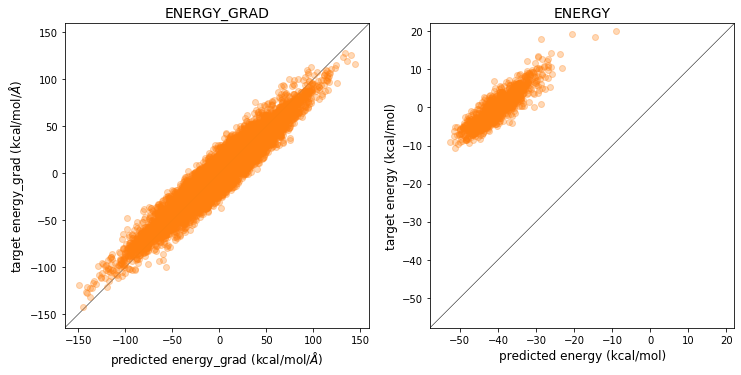

In [19]:
units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred = torch.cat(results[key], dim=0).detach().cpu().numpy()
    targ = torch.cat(targets[key], dim=0).detach().cpu().numpy()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)

plt.show()

For the DLPNO energies and forces, it is more fair to compare with the test set.

In [20]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)

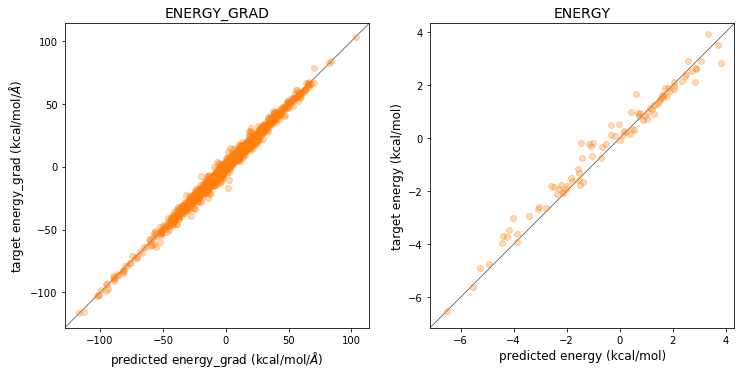

In [21]:
units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred = torch.cat(results[key], dim=0).detach().cpu().numpy()
    targ = torch.cat(targets[key], dim=0).detach().cpu().numpy()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)

plt.show()

The model is performing quite well.